<a href="https://colab.research.google.com/github/atlantiquesun/Miscellaneous/blob/master/cmv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Section 1
import glob
import json
import logging
import bz2

# Section 2
from datetime import datetime, timezone
from dateutil.relativedelta import relativedelta
import re
import numpy as np
import pandas as pd

# Section 3
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedLocator

# 1. Load Data

In [3]:
# provided code
def load_big_jsonlist(fpath):
  filenames = glob.glob(fpath)
  data = []
  for filename in filenames:
    logging.info(filename)
    with bz2.BZ2File(filename, "r") as f:
      count = 0
      for line in f:
        entry = json.loads(line)
        data.append(entry)        
        count += 1
        if count % 1000 == 0:
          logging.info(count)
    logging.info("Loading complete.")
  print('loading complete')
  return data

In [4]:
fpath = "/content/drive/MyDrive/Research/cmv/train_period_data.jsonlist.bz2"
data = load_big_jsonlist(fpath)

loading complete


# 2. Data Processing

In [5]:
def tree_contains_delta(disc_tree):
  '''
  Returns True if 'disc_tree' contains a valid delta awarded by its OP; returns False otherwise
  '''

  # get a list of comments' ids
  comments_id = [None]*len(disc_tree['comments']) # store comments' ids
  for i in range(len(disc_tree['comments'])):
    comments_id[i] = disc_tree['comments'][i]['id']

  # map ids to comments for O(1) access of a parent given parent_id
  comments_d = dict(zip(comments_id, disc_tree['comments'])) 

  # 1. linear search to find a DeltaBot's comment that contains "Confirmed" 
  # 2. if found, check if its parent is a comment by OP
  op = disc_tree['author']
  for id in comments_id:
    comment = comments_d[id]
    if(('body' in comment.keys()) and (comment['author'] == 'DeltaBot') and ('Confirmed' in comment['body'])):
      parent_id = comment['parent_id'].split('_')[1]
      if((parent_id in comments_d) and ('author' in comments_d[parent_id].keys()) and (comments_d[parent_id]['author'] == op)):
        return True

  return False

In [6]:
def std_error(row):
  '''
  Returns the standard error(%) of the average delta percentage in a month 
  (each month is represented as a row in pandas.DataFrame)
  '''

  std_dev = np.sqrt((row["delta_count"]*np.square(1-0.01*row["delta_percentage"]) 
            + (row["tree_count"]-row["delta_count"])*np.square(0.01*row["delta_percentage"]))/row["tree_count"])
  std_error = 100*(std_dev/np.sqrt(row["tree_count"]))
  return std_error


def get_delta_info(data, start_month="2013-02-01", end_month="2015-04-01"):
  '''
  Returns a pandas.DataFrame documenting 
  1. monthly discussion tree count ("tree_count")
  2. monthly number of trees that contain a valid delta awarded by OPs ("delta_count")
  3. monthly average delta percentage ("delta_percentage") 
  4. the standard error of monthly average delta percentage ("std_error")
  '''

  # initialize the pandas.DataFrame
  start_month = pd.to_datetime(start_month, utc=True)
  end_month = pd.to_datetime(end_month, utc=True)
  months = pd.date_range(start=start_month, end=end_month, freq="MS")
  df = pd.DataFrame(0, index=months, columns=["tree_count", "delta_count", "delta_percentage", "std_error"])

  # generate monthly discussion tree count and monthly number of trees that contain a valid delta from OPs
  for disc_tree in data:

    created_date = datetime.utcfromtimestamp(disc_tree["created_utc"])
    created_month = created_date.replace(day=1, hour=0, minute=0, second=0, microsecond=0, tzinfo=timezone.utc) # get the start of the corresponding month
    
    if(created_month >= start_month and created_month <= end_month):
      df.at[created_month, "tree_count"] += 1
    else:
      continue

    if(tree_contains_delta(disc_tree)):
      df.at[created_month, "delta_count"] += 1
  
  # calculate delta percentage and standard error
  df["delta_percentage"] = 100*(df["delta_count"]/df["tree_count"])
  df["std_error"] = df.apply(std_error, axis=1)
  
  df.index = [t.strftime("%Y%m") for t in list(df.index)]
  return df


In [7]:
df = get_delta_info(data)
display(df)

,tree_count,delta_count,delta_percentage,std_error
201302,111,26,23.423423,4.019867
201303,263,71,26.996198,2.737450
201304,585,150,25.641026,1.805329
201305,1115,229,20.538117,1.209824
201306,1029,224,21.768707,1.286468
201307,716,148,20.670391,1.513336
201308,959,184,19.186653,1.271545
201309,748,154,20.588235,1.478431
201310,669,148,22.122571,1.604762
201311,730,145,19.863014,1.476650


# 3. Plotting

In [8]:
def plot_delta_percentage(df, fig_path):
  '''
  Plot 'df' and save the plot to 'fig_path'
  '''

  # create a plot
  fig, ax = plt.subplots(figsize=(8, 6))
  ax.errorbar(x=list(df.index), y=df["delta_percentage"], yerr=df["std_error"], linestyle='-', marker='o', color='r')
  
  # set xticks
  major_xticks = list(range(0, len(list(df.index)), 4)) + [len(list(df.index))-1]
  ax.xaxis.set_major_locator(FixedLocator(major_xticks))
  ax.xaxis.set_minor_locator(MultipleLocator(1))
  ax.tick_params(axis='x', rotation=45, labelsize=14, which="both", direction="in", bottom=True, top=True, labelbottom=True, labeltop=False) 

  # set yticks
  ax.set_yticks([20, 30, 40])
  ax.set_yticklabels(["20%", "30%", "40%"])
  ax.tick_params(axis='y', labelsize=14) 
  plt.ylabel("delta percentage", fontsize=14)

  ax.margins(x=0.1)
  plt.savefig(fig_path, bbox_inches="tight") 
  plt.show()

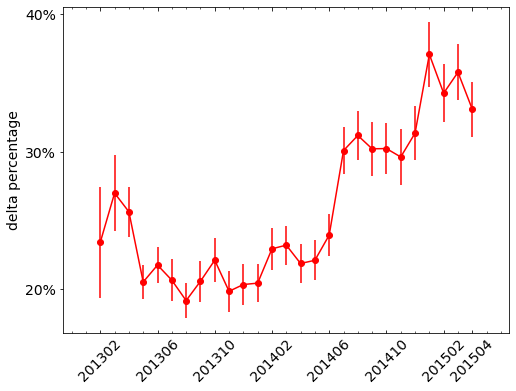

In [10]:
fig_path = "/content/drive/MyDrive/Research/cmv/delta_percentage.png"
plot_delta_percentage(df, fig_path)